# Individual Project (MSc) - Methods for Compressing Different Types of Neural Networks

This file has the full code for the project.

## Preparing the Dataset
The dataset was obtained from Kaggle, https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

In [1]:
#mount to google drive account
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
#import required modules
import os
import re
import time
import nltk
import torch

import numpy as np
import pandas as pd
from torch import nn
import seaborn as sns
from tqdm import tqdm

import torch.nn.utils.prune as prune
import torch.nn.functional as F
from torch.optim import Adam
from bs4 import BeautifulSoup
from collections import Counter
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

from nltk.stem import WordNetLemmatizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.tokenize import word_tokenize, sent_tokenize
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix

# download the NLTK resources needed
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
#import csv file using pandas
df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/IP_MSC/IMDB Dataset.csv', encoding='utf-8')

#transformation funciton to change negative values as zero and positive as one
def lbl_transform(label):
    return 1 if label == 'positive' else 0

# progress bar for pandas functions
# reference: https://www.kdnuggets.com/2022/09/progress-bars-python-tqdm-fun-profit.html
# https://towardsdatascience.com/progress-bars-in-python-and-pandas-f81954d33bae
tqdm.pandas()

# apply the transformation function in the Labels column on the IMDb dataset
df['label'] = df['sentiment'].progress_apply(lbl_transform)

# check if the changes have been applied
df.head()

100%|██████████| 50000/50000 [00:00<00:00, 831793.88it/s]


,review,sentiment,label
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1


### Cleaning up the Dataset
Need to remove the following things:
- HTML Marks including square brackets in the text
- Contracted Words
- Extra White Space
- Stemming Words
- Stopwords

References used:

https://towardsdatascience.com/nlp-building-text-cleanup-and-preprocessing-pipeline-eba4095245a0

https://www.kdnuggets.com/2018/03/text-data-preprocessing-walkthrough-python.html

https://lzone.de/examples/Python%20re.sub

https://medium.com/@yashj302/text-cleaning-using-regex-python-f1dded1ac5bd

In [ ]:
# defining stopwords for English
stopwords = set(stopwords.words('english'))

In [ ]:
# removing hyperlinks and URLs
def remove_links(text):
    return re.sub(r'https?://\S+|www\.\S+', '', text)

# removing HTML tags in text
def remove_html(text):
    return re.sub(r'<[^>]+>', '', text)

# removing regular punctuations
def remove_punctuations(text):
    return re.sub(r'[\"\#\$\%\&\'\(\)\*\+\/\:\;\<\=\>\@\[\\\]\^\_\`\{\|\}\~]', ' ', text)

# add spacing between punctations marks
def spacing4punctuations(text):
    pattern = r'([.,!?-])'
    s = re.sub(pattern, r' \1 ', text)
    s = re.sub(r'\s{2,}', ' ', s)
    return s

# removing any additional white spaces
def remove_spacing(text):
    return re.sub(r' +', ' ', text)

# removing number in text
def remove_numbers(text):
    return re.sub(r'\d+', '', text)

# removing NONASCII characters
def remove_nonascii(text):
    return re.sub(r'[^\x00-\x7f]', r'', text)

# removing emojis from text
def remove_emoji(text):
    emojis = re.compile(
        '['
        u'\U0001F600-\U0001F64F'
        u'\U0001F300-\U0001F5FF'
        u'\U0001F680-\U0001F6FF'
        u'\U0001F1E0-\U0001F1FF'
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE
    )
    return emojis.sub(r'', text)

# removes repeated characters - e.g. 'hiiii' will be 'hi'
def auto_correct(text):
    return re.sub(r'(.)\1+', r'\1\1', text)

# tokenize the text
def tokenize(text):
    return word_tokenize(text)

#removing stopwords
def remove_stopwords(text):
    return [i for i in text if i.lower() not in stopwords]

# lemmatize text
def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(t) for t in text]
    return remove_stopwords(lemmas)

# function to cleaning up the text with all the function defined above
def txt_cleanup(text):
    no_link = remove_links(text)
    no_html = remove_html(no_link)
    space_punct = spacing4punctuations(no_html)
    no_punct = remove_punctuations(space_punct)
    no_number = remove_numbers(no_punct)
    no_whitespaces = remove_spacing(no_number)
    no_nonasci = remove_nonascii(no_whitespaces)
    no_emoji = remove_emoji(no_nonasci)
    spell_corrected = auto_correct(no_emoji)
    return spell_corrected

# function to preprocess the text
def txt_processing(text):
    tokens = tokenize(text)
    no_stopwords = remove_stopwords(tokens)
    lemmas = lemmatize(no_stopwords)
    return ' '.join(lemmas)

# apply txt_cleanup function on the IMDb dataset
df['clean'] = df['review'].progress_apply(txt_cleanup)

# applying the text preprocessing function on the IMDb dataset
df['preprocessed'] = df['clean'].progress_apply(txt_processing)

# view the changes that were made on the dataset
df.head()

100%|██████████| 50000/50000 [01:50<00:00, 454.49it/s]


,review,sentiment,label,clean,preprocessed
0,One of the other reviewers has mentioned that ...,positive,1,One of the other reviewers has mentioned that ...,One reviewer mentioned watching Oz episode hoo...
1,A wonderful little production. <br /><br />The...,positive,1,A wonderful little production . The filming te...,wonderful little production . filming techniqu...
2,I thought this was a wonderful way to spend ti...,positive,1,I thought this was a wonderful way to spend ti...,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,negative,0,Basically there s a family where a little boy ...,Basically family little boy Jake think zombie ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1,Petter Mattei s Love in the Time of Money is a...,Petter Mattei Love Time Money visually stunnin...


In [ ]:
# save new dataframe with preprocessed text as a new csv file
df.to_csv('IMDb_processed.csv', index=False)

# focusing only on the processed text and the labels
# keep only processed and label columns
df[['preprocessed', 'label']].to_csv('./IMDb_processed.csv', index=False, header=True)

## Comprehensive Text Data Processing and Encoding

I have created a pipeline for processing the IMDB text data in this section. It prepares IMDB reviews by combining preprocessed reviews, segmenting the text into words, and building a vocabulary. Words are mapped to integers to encode reviews into numerical representations, and a padding token is introduced. The padding ensures that all reviews have the same length.

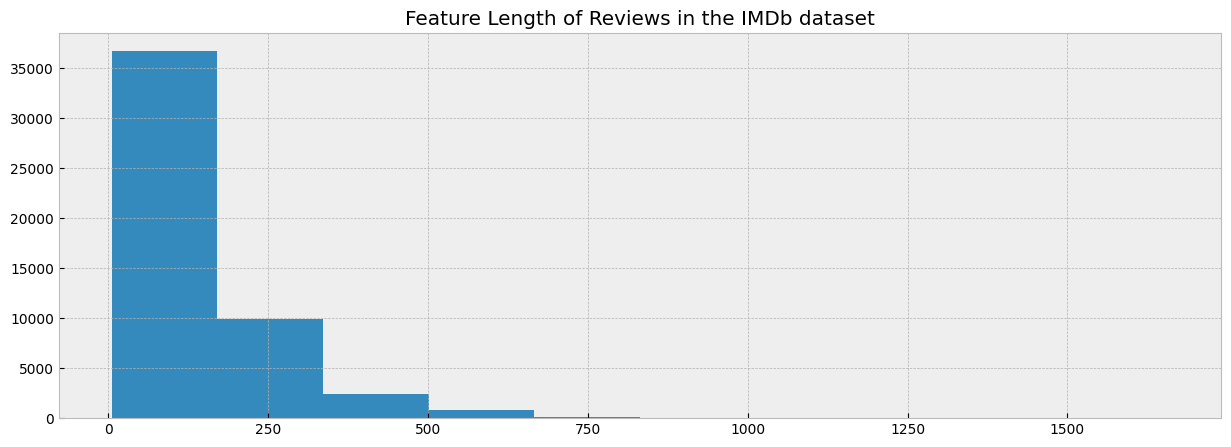

In [3]:
# path to your processed CSV file
data = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/IP_MSC/IMDb_processed.csv')

# checking the length of the processed reviews
data['review_length']=data['preprocessed'].apply(lambda x: len(x.split()))

# plotting a bar chart to view the review lengths
with plt.style.context(style='bmh'):
    data['review_length'].hist(figsize=(15,5))
    plt.title(label='Feature Length of Reviews in the IMDb dataset')
    plt.show()

In [4]:
# descriptive statistics of the processed IMDb dataset
data.describe()

,label,review_length
count,50000.000000,50000.00000
mean,0.500000,146.19428
std,0.500005,109.30604
min,0.000000,5.00000
25%,0.000000,78.00000
50%,0.500000,109.00000
75%,1.000000,178.00000
max,1.000000,1658.00000


From the processed IMDb dataset, we can see that the average review length is 146 words, and the minimum length is 5 characters long.

The maximum length of a review is 1658 characters, which is quite a lengthy review. We will have to manually review these lengthy reviews to see if we can include them or ignore them.

In [5]:
# obtaining all processed reviews
processed_reviews = data.preprocessed.values

# merging into single variable, separated by whitespaces
words = ' '.join(processed_reviews)

# obtaining a list of words
words = words.split()

# building a vocabulary and creating mappings between words and integers using a Counter
# counting the occurrences of each word
counter = Counter(words)

# sorting the words by their frequency in descending order
vocab = sorted(counter, key=counter.get, reverse=True)

# Create a mapping from integer to word
convert2integer = dict(enumerate(vocab, 1))

# Adding a special token for padding at index 0
convert2integer[0] = '<PAD>'

# creating a mapping from word to integer
convert2word = {word: id for id, word in convert2integer.items()}

# encoding the words in the reviews text
# by using the word-to-integer mapping to replace words with their integer indices
reviews_encoded = [[convert2word[word] for word in review.split()] for review in tqdm(processed_reviews)]

100%|██████████| 50000/50000 [00:02<00:00, 24366.25it/s]


In [6]:
# Padding sequences function
#processed_reviews do not have the same length so we will need set a max sequence length
def pad_features(processed_reviews, pad_id, sequence_length=128):
    # Creating a matrix to store the padded features
    features = np.full((len(processed_reviews), sequence_length), pad_id, dtype=int)
    # Looping through each review and pad or trim to the specified sequence length
    for i, row in enumerate(processed_reviews):
        # If the review is longer than sequence_length, trim it
        features[i, :len(row)] = np.array(row)[:sequence_length]
    return features

# Set the desired sequence length
sequence_length = 128

# Padding the encoded reviews using the pad_features function
features = pad_features(reviews_encoded, pad_id=convert2word['<PAD>'], sequence_length=sequence_length)

# Assertions to check the dimensions - verify whether the dimensions of the padded features match the expected values
assert len(features) == len(reviews_encoded)
assert len(features[0]) == sequence_length

# printing the first 10 rows and columns for inspection
print(features[:10, :10])

[[  172  1023   873    70  3614   167  2924     1   102     2]
 [  300    50   220     1  1204  1535 17655     3    74     3]
 [   84   300    26   983    10   788  1697  2532     2  1067]
 [ 2314   121    50   217  3121    33   607  4182   542   825]
 [70690 10390  1021  1859  7387  2190  1248     5    40     1]
 [ 2691     3    10   337     4     2    13 42241     2  2846]
 [  178    14     8    17 12322  1823 55638   106  4989   379]
 [   27   389     2  1276  3908   147    30  2854     1    30]
 [47622   922   330     5   162   722    70     5     1  1242]
 [    8   110  2179  5479  1896     8     4     1   107    74]]


In [7]:
# create numpy array for labels column
labels = data.label.to_numpy()

## Splitting the Dataset to Training and Testing

We divide the dataset into three parts - training, validation, and test sets. 70% data is allocated for training and the remaining 30% for validation and testing. We separate the features and labels accordingly, print their shapes, and display the class distribution within each set to understand how the binary classes are balanced. This process is crucial for reliable model development and assessment.

In [8]:
# setting values for training and testing
train_size = 0.7  # use 70% of the data as the training set
val_size = 0.3    # use 30% of the remaining data as the validation set

# making the training set
# calculating the index to split the features and labels for the training set
split_id = int(len(features) * train_size)
# splitting the features into the training set
X_train, X_remainder = features[:split_id], features[split_id:]
# splitting the labels into the training set
Y_train, Y_remainder = labels[:split_id], labels[split_id:]

# making the validation and testing set
# calculating the index to split the remaining data into validation and test sets
split_val_id = int(len(X_remainder) * val_size)
# splitting the remaining features into validation and test sets
X_validation, X_test = X_remainder[:split_val_id], X_remainder[split_val_id:]
# splitting the remaining labels into validation and test sets
Y_validation, Y_test = Y_remainder[:split_val_id], Y_remainder[split_val_id:]

In [9]:
# Printing out the shape of the datasets
print('Feature Shapes:')
print('===============')
# Print the shape of the training set features
print('Training set: {}'.format(X_train.shape))
print()
# Print the shape of the validation set features
print('Validation set: {}'.format(X_validation.shape))
print()
# Print the shape of the test set features
print('Testing set: {}'.format(X_test.shape))
print()
print('===============')
# Print the class distribution in each set
print("Class Distribution in Training Set:")
# Print the count of each class in the training set
print(f"Class 0: {len(Y_train[Y_train == 0])}, Class 1: {len(Y_train[Y_train == 1])}")
# Print the count of each class in the validation set
print("\nClass Distribution in Validation Set:")
print(f"Class 0: {len(Y_validation[Y_validation == 0])}, Class 1: {len(Y_validation[Y_validation == 1])}")
# Print the count of each class in the test set
print("\nClass Distribution in Test Set:")
print(f"Class 0: {len(Y_test[Y_test == 0])}, Class 1: {len(Y_test[Y_test == 1])}")

Feature Shapes:
Training set: (35000, 128)

Validation set: (4500, 128)

Testing set: (10500, 128)

Class Distribution in Training Set:
Class 0: 17510, Class 1: 17490

Class Distribution in Validation Set:
Class 0: 2243, Class 1: 2257

Class Distribution in Test Set:
Class 0: 5247, Class 1: 5253


Now, we have a **batch size of 64** for efficient training and three PyTorch TensorDatasets: **training_set**, **validation_set**, and **testing_set**. Three DataLoader instances initialize with batch size and enable shuffling for training and validation sets.

The code checks a sample batch from the training loader to provide insights into the  structure of the processed dataset.

In [10]:
# Defining the batch size
batch_size = 128

# Creating tensor datasets
training_set = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(Y_train))
validation_set = TensorDataset(torch.from_numpy(X_validation), torch.from_numpy(Y_validation))
testing_set = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(Y_test))

# Creating data loaders
training_loader = DataLoader(training_set, shuffle=True, batch_size=batch_size)
validation_loader = DataLoader(validation_set, shuffle=True, batch_size=batch_size)
testing_loader = DataLoader(testing_set, shuffle=True, batch_size=batch_size)

# Checking sample batches from the training loader
dataiteration = iter(training_loader)
x, y = next(dataiteration)

In [11]:
# Display details of the sample batch
print('Sample Batch Information:')
print('-------------------------')
print('Input Size: ', x.size())   # Display the size of the input batch (batch_size, seq_length)
print('Input Batch:\n', x)        # Display the input batch
print()
print('Label Size: ', y.size())   # Display the size of the label batch (batch_size)
print('Label Batch:\n', y)        # Display the label batch

Sample Batch Information:
-------------------------
Input Size:  torch.Size([128, 128])
Input Batch:
 tensor([[   55,  6144,     1,  ...,   295,   476,    20],
        [ 1729,    28,     3,  ...,     0,     0,     0],
        [  105,   304,  3767,  ...,     0,     0,     0],
        ...,
        [22397, 46824,  2142,  ...,     2,  5543,   183],
        [10466, 18068,   480,  ...,     0,     0,     0],
        [26952,    65,   329,  ...,     0,     0,     0]])

Label Size:  torch.Size([128])
Label Batch:
 tensor([1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0,
        1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
        1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
        1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0,
        1, 0, 1, 1, 0, 1, 1, 0])


## LSTM-based model for Sentiment Analysis



In [12]:
torch.cuda.is_available()
# ref: https://stackoverflow.com/questions/50560395/how-to-install-cuda-in-google-colab-gpus
# Output would be True if Pytorch is using GPU otherwise it would be False.

# define training device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [13]:
# LSTM Model architecture for sentiment analysis
# reference used: https://galhever.medium.com/sentiment-analysis-with-pytorch-part-3-cnn-model-7bb30712abd7
class Sentiment_LSTM(nn.Module):
    def __init__(self, vocab_size, output_size, hidden_size=128, embedding_size=400, n_layers=2, dropout=0.2):
        super(Sentiment_LSTM, self).__init__()

        # Embedding layer to map input tokens into vector representations
        self.embedding = nn.Embedding(vocab_size, embedding_size)

        # LSTM layer provided by PyTorch library
        self.lstm = nn.LSTM(embedding_size, hidden_size, n_layers, dropout=dropout, batch_first=True)

        # Dropout layer for regularization
        self.dropout = nn.Dropout(0.3)

        # Linear layer for the final output
        self.fc = nn.Linear(hidden_size, output_size)

        # Sigmoid layer as we are performing binary classification
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Convert input features to the 'long' data type
        x = x.long()

        # Map input tokens to vector representations using the embedding layer
        x = self.embedding(x)

        # Pass the input forward through the LSTM layer
        o, _ = self.lstm(x)

        # Retrieve the last output of the sequence
        o = o[:, -1, :]

        # Apply dropout and pass through the fully connected layer
        o = self.dropout(o)
        o = self.fc(o)

        # Apply sigmoid activation for binary classification
        o = self.sigmoid(o)

        return o

In [14]:
# Model hyperparameters
vocab_size = len(convert2word)  # size of the vocabular; assuming `convert2word` is a mapping of words to unique integer indices
output_size = 1 # size of the output, typically 1 for binary classification (positive or negative sentiment)
embedding_size = 256 #dimensionality of embedding vectors used to represent each token in the input
hidden_size = 512 #number of hidden units in the LSTM layer
n_layers = 2 #number of layers in the LSTM model
dropout = 0.25 #dropout rate; regularization technique applied to prevent overfitting by randomly dropping units during training

In [15]:
# Model initialization
model = Sentiment_LSTM(vocab_size, output_size, hidden_size, embedding_size, n_layers, dropout)
print(model)

Sentiment_LSTM(
  (embedding): Embedding(120982, 256)
  (lstm): LSTM(256, 512, num_layers=2, batch_first=True, dropout=0.25)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [16]:
# Training configuration
lr = 0.001  # Learning rate
criterion = nn.BCELoss()  # Loss function: Binary Cross Entropy Loss for binary classification
optim = Adam(model.parameters(), lr=lr)  # Optimizer: Adam optimizer with the specified learning rate
grad_clip = 5  # Gradient clipping threshold to prevent large gradients
epochs = 10  # Number of times the entire dataset is passed through the model during training
print_every = 1  # Frequency of printing training progress information (every 'print_every' epochs)
history = {
    'training_loss': [],          # List to store training loss over epochs
    'training_accuracy': [],      # List to store training accuracy over epochs
    'validation_loss': [],        # List to store validation loss over epochs
    'validation_accuracy': [],    # List to store validation accuracy over epochs
    'epochs': epochs              # Total number of epochs
}
es_limit = 5  # Early stopping limit; Maximum consecutive epochs without improvement in validation loss

In [33]:
# Training loop
# Move the model to the specified device (GPU or CPU)
model = model.to(device)

# Create a tqdm progress bar over the range of epochs
# - 'position=0': Display the progress bar at the top
# - 'desc='Training'': Description to display in the progress bar
# - 'leave=True': Leave the progress bar displayed after completion
epochloop = tqdm(range(epochs), position=0, desc='Training', leave=True)

# Set patience to control early stopping behavior
patience = 20
# Early stop trigger
es_trigger = 0

# Minimum validation loss initialized to positive infinity
# Used to track the lowest validation loss encountered during training
validation_loss_min = np.Inf

# Training and Validation Loop
# reference used: https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel
for e in epochloop:

    # Training mode
    # Set the model to training mode to enable gradient calculation
    model.train()

    # Initialize training metrics
    training_loss = 0
    training_accuracy = 0

    # Iterate over training batches
    for id, (feature, target) in enumerate(training_loader):
        # Add epoch meta info
        epochloop.set_postfix_str(f'Training batch {id}/{len(training_loader)}')

        # Move data to the specified device (GPU or CPU)
        feature, target = feature.to(device), target.to(device)

        # Reset optimizer gradients
        optim.zero_grad()

        # Forward pass
        out = model(feature)

        # Calculate accuracy
        predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
        equals = predicted == target
        acc = torch.mean(equals.type(torch.FloatTensor))
        training_accuracy += acc.item()

        # Calculate loss and perform backpropagation
        loss = criterion(out.squeeze(), target.float())
        training_loss += loss.item()
        loss.backward()

        # Clip gradients to prevent exploding gradients
        nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

        # Update optimizer
        optim.step()

        del feature, target, predicted

    # Store training metrics
    history['training_loss'].append(training_loss / len(training_loader))
    history['training_accuracy'].append(training_accuracy / len(training_loader))

    # Validation mode
    # Set the model to evaluation mode to disable gradient calculation
    model.eval()

    # Initialize validation metrics
    validation_loss = 0
    validation_accuracy = 0

    with torch.no_grad():
        # Iterate over validation batches
        for id, (feature, target) in enumerate(validation_loader):
            # Add epoch meta info
            epochloop.set_postfix_str(f'Validation batch {id}/{len(validation_loader)}')

            # Move data to the specified device (GPU or CPU)
            feature, target = feature.to(device), target.to(device)

            # Forward pass
            out = model(feature)

            # Calculate accuracy
            predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
            equals = predicted == target
            acc = torch.mean(equals.type(torch.FloatTensor))
            validation_accuracy += acc.item()

            # Calculate loss
            loss = criterion(out.squeeze(), target.float())
            validation_loss += loss.item()

            # Free some memory
            del feature, target, predicted

        # Store validation metrics
        history['validation_loss'].append(validation_loss / len(validation_loader))
        history['validation_accuracy'].append(validation_accuracy / len(validation_loader))

    # Reset model to training mode
    model.train()

    # Add epoch meta info
    epochloop.set_postfix_str(f'Validation Loss: {validation_loss / len(validation_loader):.3f} | Validation Accuracy: {validation_accuracy / len(validation_loader):.3f}')

    # Print epoch information
    if (e+1) % print_every == 0:
        epochloop.write(f'Epoch {e+1}/{epochs} | Training Loss: {training_loss / len(training_loader):.3f} Training Accuracy: {training_accuracy / len(training_loader):.3f} | Validation Loss: {validation_loss / len(validation_loader):.3f} Val Acc: {validation_accuracy / len(validation_loader):.3f}')
        epochloop.update()

    # Save model if validation loss decreases
    if validation_loss / len(validation_loader) <= validation_loss_min:
        torch.save(model.state_dict(), './sentiment_lstm.pt')
        validation_loss_min = validation_loss / len(validation_loader)
        es_trigger = 0
    else:
        epochloop.write(f'WARNING - Validation loss did not improve ({validation_loss_min:.3f} --> {validation_loss / len(validation_loader):.3f})')
        es_trigger += 1

    # Force early stop
    if es_trigger >= es_limit:
        epochloop.write(f'Early stopping at Epoch-{e+1}')
        history['epochs'] = e+1 # Update epochs history
        break

Training:  10%|█         | 1/10 [00:15<02:16, 15.19s/it, Validation Loss: 0.617 | Validation Accuracy: 0.857]

Epoch 1/10 | Training Loss: 0.035 Training Accuracy: 0.993 | Validation Loss: 0.617 Val Acc: 0.857


Training:  30%|███       | 3/10 [00:30<01:13, 10.44s/it, Training batch 4/274]

Epoch 2/10 | Training Loss: 0.030 Training Accuracy: 0.993 | Validation Loss: 0.624 Val Acc: 0.860
WARNING - Validation loss did not improve (0.617 --> 0.624)


Training:  50%|█████     | 5/10 [00:46<01:01, 12.31s/it, Training batch 4/274]

Epoch 3/10 | Training Loss: 0.024 Training Accuracy: 0.995 | Validation Loss: 0.677 Val Acc: 0.855
WARNING - Validation loss did not improve (0.617 --> 0.677)


Training:  60%|██████    | 6/10 [01:01<00:39,  9.80s/it, Training batch 3/274]

Epoch 4/10 | Training Loss: 0.019 Training Accuracy: 0.996 | Validation Loss: 0.681 Val Acc: 0.850
WARNING - Validation loss did not improve (0.617 --> 0.681)


Training:  80%|████████  | 8/10 [01:16<00:22, 11.28s/it, Training batch 4/274]

Epoch 5/10 | Training Loss: 0.020 Training Accuracy: 0.996 | Validation Loss: 0.711 Val Acc: 0.856
WARNING - Validation loss did not improve (0.617 --> 0.711)


Training:  50%|█████     | 5/10 [01:31<01:31, 18.30s/it, Validation Loss: 0.756 | Validation Accuracy: 0.856]

Epoch 6/10 | Training Loss: 0.014 Training Accuracy: 0.997 | Validation Loss: 0.756 Val Acc: 0.856
WARNING - Validation loss did not improve (0.617 --> 0.756)
Early stopping at Epoch-6


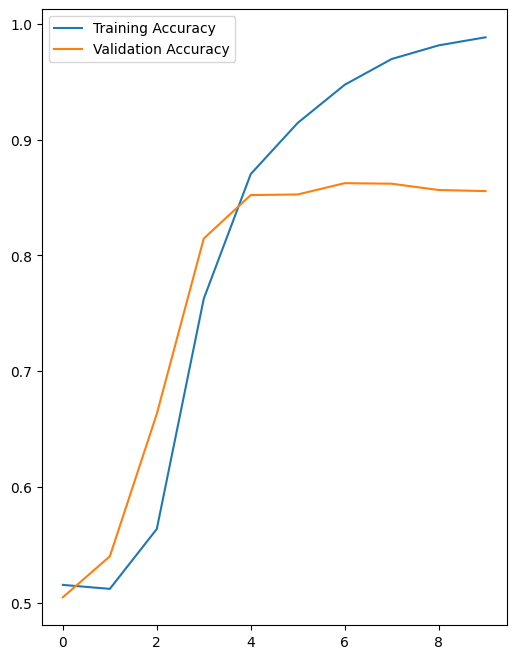

In [18]:
# Plotting loss over epochs for training and validation accuracy
plt.figure(figsize=(6, 8))
plt.plot(range(history['epochs']), history['training_accuracy'], label='Training Accuracy')
plt.plot(range(history['epochs']), history['validation_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

In [19]:
# Predicting data with unseen data which wasn't included in training
# Test loop
model.eval()

# Metrics for testing
test_loss = 0
test_acc = 0

# Lists to store true target values and predicted values for later evaluation
all_target = []
all_predicted = []

# tqdm progress bar for the test loop
testloop = tqdm(testing_loader, leave=True, desc='Inference')
with torch.no_grad():
    for feature, target in testloop:
        # Move data to the specified device (GPU or CPU)
        feature, target = feature.to(device), target.to(device)

        # Forward pass
        out = model(feature)

        # Calculate accuracy
        predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
        equals = predicted == target
        acc = torch.mean(equals.type(torch.FloatTensor))
        test_acc += acc.item()

        # Calculate loss
        loss = criterion(out.squeeze(), target.float())
        test_loss += loss.item()

        # Extend lists with true and predicted values
        all_target.extend(target.cpu().numpy())
        all_predicted.extend(predicted.cpu().numpy())

    # Print overall accuracy and loss for the test set
    print(f'Accuracy: {test_acc/len(testing_loader):.4f}, Loss: {test_loss/len(testing_loader):.4f}')

# Print out classification report
print(classification_report(all_predicted, all_target))

Inference: 100%|██████████| 83/83 [00:01<00:00, 53.43it/s]

Accuracy: 0.8527, Loss: 0.5285
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      5049
           1       0.87      0.84      0.86      5451

    accuracy                           0.85     10500
   macro avg       0.85      0.85      0.85     10500
weighted avg       0.85      0.85      0.85     10500



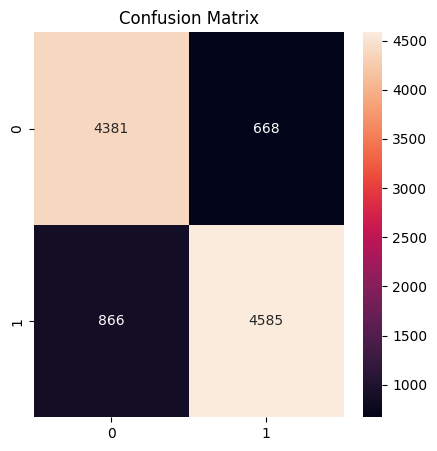

In [20]:
# Plot confusion matrix
cm = confusion_matrix(all_predicted, all_target)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.show()

## Pruning the LSTM model

Inspecting the model before applying pruning on it.

In [34]:
# Specifying the layer to inspect before pruning
layer_to_inspect = 'fc' # fc - fully connected

# Extract the specified module
module_to_inspect = getattr(model, layer_to_inspect, None)

# Print named parameters of the module before pruning
print("Named Parameters of the Module Before Pruning:")
print(list(module_to_inspect.named_parameters()))

Named Parameters of the Module Before Pruning:
[('bias', Parameter containing:
tensor([0.0843], device='cuda:0', requires_grad=True)), ('weight_orig', Parameter containing:
tensor([[-3.4073e-02, -1.9792e-01,  5.7009e-03, -6.8027e-03,  5.5232e-02,
          9.5788e-03, -2.0476e-01, -4.5407e-02, -6.7228e-02,  3.8910e-02,
         -3.6645e-03,  2.4776e-02,  2.4955e-02, -2.9234e-02,  2.4239e-01,
          5.3681e-03,  7.7829e-02, -1.8862e-02,  1.0326e-02,  1.0313e-02,
          3.4313e-02, -1.3882e-03,  1.3483e-02,  1.6973e-01, -6.1226e-02,
          8.3498e-03,  3.0786e-02, -2.0980e-01, -6.0607e-02,  7.6470e-02,
          7.4103e-02,  9.3934e-03,  4.9955e-03, -3.2054e-02, -3.2294e-02,
         -1.4935e-01, -7.9760e-02,  4.4247e-03, -5.0761e-02,  6.5128e-02,
         -1.1722e-02,  1.9234e-01, -1.6596e-02, -1.1843e-02,  1.4985e-01,
         -1.7254e-02, -1.3986e-02,  2.2939e-03, -5.1119e-03,  2.6315e-02,
         -1.2358e-02,  7.3113e-02, -3.5863e-02,  5.8595e-03,  3.1670e-03,
          3.2

In [35]:
# Print named buffers of the module before pruning
print("Named Buffers of the Module Before Pruning:")
print(list(module_to_inspect.named_buffers()))

Named Buffers of the Module Before Pruning:
[('weight_mask', tensor([[0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
         0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,

In [36]:
# Print the weight tensor of the module before pruning
print("Weight Tensor of the Module Before Pruning:")
print(module_to_inspect.weight)

Weight Tensor of the Module Before Pruning:
tensor([[-0.0000, -0.1979,  0.0000, -0.0000,  0.0000,  0.0000, -0.2048, -0.0000,
         -0.0000,  0.0000, -0.0000,  0.0000,  0.0000, -0.0000,  0.2424,  0.0000,
          0.0000, -0.0000,  0.0000,  0.0000,  0.0000, -0.0000,  0.0000,  0.1697,
         -0.0000,  0.0000,  0.0000, -0.2098, -0.0000,  0.0000,  0.0000,  0.0000,
          0.0000, -0.0000, -0.0000, -0.1494, -0.0000,  0.0000, -0.0000,  0.0000,
         -0.0000,  0.1923, -0.0000, -0.0000,  0.1498, -0.0000, -0.0000,  0.0000,
         -0.0000,  0.0000, -0.0000,  0.0000, -0.0000,  0.0000,  0.0000,  0.0000,
          0.0000, -0.0000, -0.0000,  0.0000, -0.0000,  0.2380, -0.0000,  0.0000,
         -0.0000,  0.1282, -0.0000, -0.2035,  0.0000,  0.0000,  0.0000, -0.0000,
         -0.0000, -0.1947,  0.0000,  0.0000,  0.0000, -0.0000, -0.1965,  0.0000,
          0.0000,  0.0000,  0.0000, -0.0000, -0.2098, -0.0000,  0.0000,  0.2215,
         -0.2722,  0.1553, -0.0000, -0.0000,  0.0000,  0.0000, -0

In [37]:
# Print the forward pre-hooks of the module before pruning
print("Forward Pre-hooks of the Module Before Pruning:")
print(module_to_inspect._forward_pre_hooks)

Forward Pre-hooks of the Module Before Pruning:
OrderedDict([(5, <torch.nn.utils.prune.PruningContainer object at 0x7be761419090>)])


The code below applies pruning to a neural network model, specifiThe code applies pruning to a neural network model by targeting the fully connected (fc) layer. The layer to be pruned is specified as 'fc', and 30% of its connections are pruned using the L1 unstructured pruning method. This method removes a percentage of the smallest magnitude connections in the layer, which promotes sparsity in the model and reduces its computational complexity.cally targeting the fully connected (fc) layer. The layer to be pruned is specified as 'fc', and 30% of its connections are pruned using the L1 unstructured pruning method. L1 unstructured pruning removes a percentage of the smallest magnitude connections in the specified layer, enabling sparsity in the model and reducing its computational complexity.

Reference:

https://pytorch.org/tutorials/intermediate/pruning_tutorial.html

https://towardsdatascience.com/how-to-prune-neural-networks-with-pytorch-ebef60316b91

In [38]:
# applying pruning on the fully connected layer (fc)
module = model.fc

# Percentage of connections to prune
prune_percentage = 30

# Use L1Unstructured pruning method
prune.l1_unstructured(module, name='weight', amount=prune_percentage / 100.0)
# reference: https://towardsdatascience.com/how-to-prune-neural-networks-with-pytorch-

# Printing named parameters of the pruned module - include the weights and biases associated with the pruned module
print("Named Parameters of the Pruned Module:")
print(list(module.named_parameters()))

Named Parameters of the Pruned Module:
[('bias', Parameter containing:
tensor([0.0843], device='cuda:0', requires_grad=True)), ('weight_orig', Parameter containing:
tensor([[-3.4073e-02, -1.9792e-01,  5.7009e-03, -6.8027e-03,  5.5232e-02,
          9.5788e-03, -2.0476e-01, -4.5407e-02, -6.7228e-02,  3.8910e-02,
         -3.6645e-03,  2.4776e-02,  2.4955e-02, -2.9234e-02,  2.4239e-01,
          5.3681e-03,  7.7829e-02, -1.8862e-02,  1.0326e-02,  1.0313e-02,
          3.4313e-02, -1.3882e-03,  1.3483e-02,  1.6973e-01, -6.1226e-02,
          8.3498e-03,  3.0786e-02, -2.0980e-01, -6.0607e-02,  7.6470e-02,
          7.4103e-02,  9.3934e-03,  4.9955e-03, -3.2054e-02, -3.2294e-02,
         -1.4935e-01, -7.9760e-02,  4.4247e-03, -5.0761e-02,  6.5128e-02,
         -1.1722e-02,  1.9234e-01, -1.6596e-02, -1.1843e-02,  1.4985e-01,
         -1.7254e-02, -1.3986e-02,  2.2939e-03, -5.1119e-03,  2.6315e-02,
         -1.2358e-02,  7.3113e-02, -3.5863e-02,  5.8595e-03,  3.1670e-03,
          3.2569e-02,

In [39]:
# Printing named buffers of the pruned module
print("Named Buffers of the Pruned Module:")
print(list(module.named_buffers()))

Named Buffers of the Pruned Module:
[('weight_mask', tensor([[0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,

In [40]:
# Printing the weight tensor of the pruned module
print("Weight Tensor of the Pruned Module:")
print(module.weight)

Weight Tensor of the Pruned Module:
tensor([[-0.0000, -0.1979,  0.0000, -0.0000,  0.0000,  0.0000, -0.2048, -0.0000,
         -0.0000,  0.0000, -0.0000,  0.0000,  0.0000, -0.0000,  0.2424,  0.0000,
          0.0000, -0.0000,  0.0000,  0.0000,  0.0000, -0.0000,  0.0000,  0.1697,
         -0.0000,  0.0000,  0.0000, -0.2098, -0.0000,  0.0000,  0.0000,  0.0000,
          0.0000, -0.0000, -0.0000, -0.0000, -0.0000,  0.0000, -0.0000,  0.0000,
         -0.0000,  0.1923, -0.0000, -0.0000,  0.0000, -0.0000, -0.0000,  0.0000,
         -0.0000,  0.0000, -0.0000,  0.0000, -0.0000,  0.0000,  0.0000,  0.0000,
          0.0000, -0.0000, -0.0000,  0.0000, -0.0000,  0.2380, -0.0000,  0.0000,
         -0.0000,  0.0000, -0.0000, -0.2035,  0.0000,  0.0000,  0.0000, -0.0000,
         -0.0000, -0.1947,  0.0000,  0.0000,  0.0000, -0.0000, -0.1965,  0.0000,
          0.0000,  0.0000,  0.0000, -0.0000, -0.2098, -0.0000,  0.0000,  0.2215,
         -0.2722,  0.0000, -0.0000, -0.0000,  0.0000,  0.0000, -0.2028,  

In [41]:
# Printing the forward pre-hooks of the pruned module
print("Forward Pre-hooks of the Pruned Module:")
print(module._forward_pre_hooks)

Forward Pre-hooks of the Pruned Module:
OrderedDict([(6, <torch.nn.utils.prune.PruningContainer object at 0x7be761419090>)])


*   L1 unstructured pruning method removes the specified percentage of smallest magnitude connections
*   Buffers may contain auxiliary non-learnable parameters associated with the module
*   Pre-hooks are functions registered to be called before the forward pass of the module




/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_pca.py:543: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)


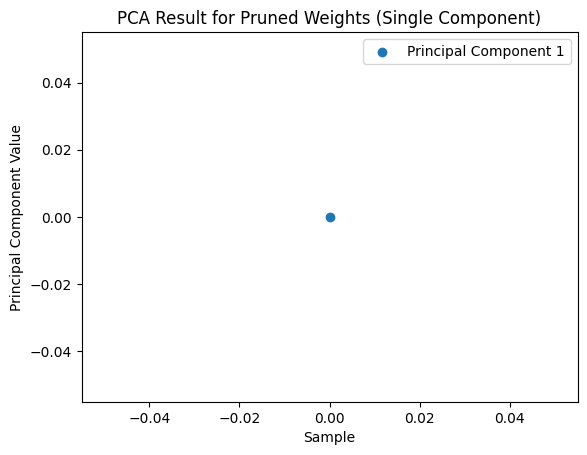

In [57]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Specify the layer to prune
layer_to_prune = 'fc'

# Extracting the specified module
module_to_prune = getattr(model, layer_to_prune, None)

# Apply pruning using L1Unstructured method
prune_percentage = 30
prune.l1_unstructured(module_to_prune, name='weight', amount=prune_percentage / 100.0)

# Get the pruned weight tensor
pruned_weights = module_to_prune.weight.detach().cpu().numpy()

# Reshape the weight tensor if it's 2D (for fully connected layers)
if pruned_weights.ndim == 2:
    pruned_weights = pruned_weights.reshape(-1, pruned_weights.shape[-1])

# Apply PCA
num_components = min(pruned_weights.shape[0], pruned_weights.shape[1])
pca = PCA(n_components=num_components)
pca_result = pca.fit_transform(pruned_weights)

# Visualize the PCA result
num_components_to_visualize = min(2, num_components)

# Adjust the plotting based on the shape of pca_result
if num_components_to_visualize == 1:
    plt.scatter(range(len(pca_result)), pca_result[:, 0], label='Principal Component 1')
    plt.title('PCA Result for Pruned Weights (Single Component)')
    plt.xlabel('Sample')
    plt.ylabel('Principal Component Value')
    plt.legend()
    plt.show()
elif num_components_to_visualize == 2:
    plt.scatter(pca_result[:, 0], pca_result[:, 1], label='Principal Components 1 & 2')
    plt.title('PCA Result for Pruned Weights')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


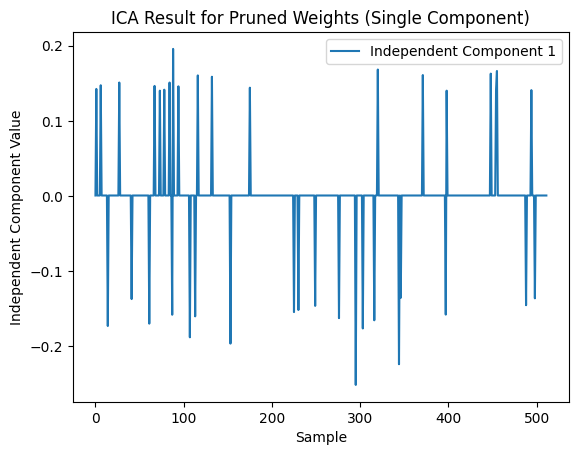

In [54]:
from sklearn.decomposition import FastICA

# Specify the layer to prune
layer_to_prune = 'fc'

# Extract the specified module
module_to_prune = getattr(model, layer_to_prune, None)

# Apply pruning using L1Unstructured method
prune_percentage = 30
prune.l1_unstructured(module_to_prune, name='weight', amount=prune_percentage / 100.0)

# Get the pruned weight tensor
pruned_weights = module_to_prune.weight.detach().cpu().numpy()

# Reshape the weight tensor if it's 2D (for fully connected layers)
if pruned_weights.ndim == 2:
    pruned_weights = pruned_weights.reshape(-1, pruned_weights.shape[-1])

# Apply FastICA
num_components = min(pruned_weights.shape[0], pruned_weights.shape[1])
ica = FastICA(n_components=num_components)

# Transpose the input if it's a 1D array
if pruned_weights.shape[0] == 1:
    pruned_weights = pruned_weights.T

ica_result = ica.fit_transform(pruned_weights)

# Visualize the ICA result
num_components_to_visualize = min(2, num_components)

# Adjust the plotting based on the shape of ica_result
if ica_result.shape[1] == 1:
    plt.plot(ica_result[:, 0], label='Independent Component 1')
    plt.title('ICA Result for Pruned Weights (Single Component)')
    plt.xlabel('Sample')
    plt.ylabel('Independent Component Value')
    plt.legend()
    plt.show()
elif ica_result.shape[1] == 2:
    for i in range(num_components_to_visualize):
        plt.scatter(ica_result[:, i], label=f'Independent Component {i+1}')

    plt.title('ICA Result for Pruned Weights')
    plt.xlabel('Sample')
    plt.ylabel('Independent Component Value')
    plt.legend()
    plt.show()
